# LRS2 advanced reductions from raw data (LRS2Raw)

This notebook is an introduction to using LRS2Raw and LRS2Multi, which operates from raw data products to perform advanced sky subtraction, object detection, object extraction, cube creation, or stacking multiple observations. The details of the code can be found in https://github.com/grzeimann/LRS2Multi, and this notebook serves as a use-case demonstration.

The first cell is long and constructs functions to find data from a program(s) as well as load the necessary modules. For the beginning, simply execute the first cell and move to the next step. If you run into issues, please contact Greg Zeimann (gregz@astro.as.utexas.edu)

In [28]:
import sys
sys.path.append("..") 

import glob
import matplotlib.pyplot as plt
import os.path as op
import numpy as np
import seaborn as sns
import tarfile

from astropy.convolution import convolve, Gaussian1DKernel
from astropy.io import fits
from astropy.stats import biweight_midvariance
from fiber_utils import get_fiber_to_fiber, find_peaks
from lrs2multi import LRS2Multi
from lrs2object import LRS2Object
from lrs2raw import LRS2Raw
from virusraw import VIRUSRaw
from scipy.signal import medfilt

%matplotlib inline

sns.set_context('talk')
sns.set_style('ticks')
plt.rcParams["font.family"] = "Times New Roman"

def get_objects(dates, instrument='lrs2', rootdir='/work/03946/hetdex/maverick'):
    tarfolders = []
    for date in dates:
        tarnames = sorted(glob.glob(op.join(rootdir, date, instrument, '%s0000*.tar' % instrument)))
        for t in tarnames:
            tarfolders.append(t)
    objectdict = {}
    for tarfolder in tarfolders:
        date = tarfolder.split('/')[-3]
        obsnum = int(tarfolder[-11:-4])
        NEXP = 1
        T = tarfile.open(tarfolder, 'r')
        try:
            names_list = T.getnames()
            names_list = [name for name in names_list if name[-5:] == '.fits']
            exposures = np.unique([name.split('/')[1] for name in names_list])
            b = fits.open(T.extractfile(T.getmember(names_list[0])))
            Target = b[0].header['OBJECT']
            NEXP = len(exposures)
            for i in np.arange(NEXP):
                objectdict['%s_%07d_%02d' % (date, obsnum, i+1)] = Target
        except:
            objectdict['%s_%07d_%02d' % (date, obsnum, NEXP)] = ''
            continue
    return objectdict

def get_ftf_correction(twiRaw_list, sciRaw_list, side='blue'):
    if not twiRaw_list:
        print('No Twi Exposures in twiRaw_list')
        return None
    if not sciRaw_list:
        print('No Science Exposures in sciRaw_list, %s side' % side)
        return None
    if side == 'blue':
        channels = ['uv', 'orange']
    else:
        channels = ['red', 'farred']
    for channel in channels:
        twidata = 0 * twiRaw_list[0].info[channel].data
        twidatae = 0 * twiRaw_list[0].info[channel].datae
        wave = twiRaw_list[0].info[channel].def_wave
        for twi in twiRaw_list:
            twidata[:] += twi.info[channel].data*1e17
            twidatae[:] += (twi.info[channel].data*1e17)**2
        twidatae = np.sqrt(twidatae)
        ftf, mask = get_fiber_to_fiber(twidata, twidatae, wave)
        for sciRaw in sciRaw_list:
            sciRaw.info[channel].ftf /= ftf
            sciRaw.info[channel].data /= ftf
            sciRaw.info[channel].datae /= ftf
        
def get_wave_correction(arcRaw_list, sciRaw_list, side='blue'):
    if not arcRaw_list:
        print('No Arc Exposures in arcRaw_list')
        return None
    if not sciRaw_list:
        print('No Science Exposures in sciRaw_list, %s side' % side)
        return None
    if side == 'blue':
        channels = ['uv', 'orange']
    else:
        channels = ['red', 'farred']
    for channel in channels:
        def_wave = arcRaw_list[0].info[channel].def_wave
        arc_spectra = 0. * arcRaw_list[0].info[channel].data
        for arc in arcRaw_list:
            arc_spectra[:] += arc.info[channel].data*1e17
        lines = np.array(line_list[channel])
        std = np.sqrt(biweight_midvariance(arc_spectra, ignore_nan=True))
        matches = np.ones((arc_spectra.shape[0], len(lines))) * np.nan
        for i, spec in enumerate(arc_spectra):
            xloc, h = find_peaks(spec, thresh=std*15.)
            if len(xloc) == 0.:
                continue
            waves = np.interp(xloc, np.arange(len(def_wave)), def_wave)
            for j, line in enumerate(lines):
                ind = np.argmin(np.abs(waves - line))
                dist = np.abs(waves[ind] - line)
                if dist < 5.:
                    matches[i, j] = waves[ind]
        model = matches * 0.
        G = Gaussian1DKernel(4.)
        for j in np.arange(len(lines)):       
            model[:, j] = convolve(matches[:, j] - lines[j], G, boundary='wrap')
        wave_correction = 0. * arc_spectra
        for i, spec in enumerate(arc_spectra):
            sel = np.isfinite(model[i])
            wave_correction[i] = np.polyval(np.polyfit(lines[sel], model[i][sel], 2), 
                                            def_wave)
            for science in sciRaw_list:
                science.info[channel].data[i] = np.interp(def_wave,
                                                          def_wave-wave_correction[i],
                                                          science.info[channel].data[i])
                science.info[channel].datae[i] = np.interp(def_wave,
                                                           def_wave-wave_correction[i],
                                                           science.info[channel].datae[i])
        for science in sciRaw_list:
            science.info[channel].wave_correction = wave_correction
    return None

def make_quick_plot(LRS2, inner_sky_radius=2., outer_sky_radius=4.):
    fig, ax = plt.subplots(1, 2, figsize=(18, 6))
    for f_ax10 in ax:
        f_ax10.tick_params(axis='both', which='both', direction='in')
        f_ax10.tick_params(axis='y', which='both', left=True, right=True)
        f_ax10.tick_params(axis='x', which='both', bottom=True, top=True)
        f_ax10.tick_params(axis='both', which='major', length=8, width=2)
        f_ax10.tick_params(axis='both', which='minor', length=5, width=1)
        f_ax10.minorticks_on()
    ax[0].set_position([0.15, 0.15, 0.5, 0.75])
    ax[1].set_position([0.7, 0.15, 0.25, 0.75])
    wave = LRS2.spec1D.spectral_axis.value
    flux =  LRS2.spec1D.flux.value / 1e-17 * response
    ax[0].plot(wave, flux, 'k-', lw=1)
    ax[0].set_ylim([0, 12])
    ax[1].set_xlim([-8, 8])
    ax[1].set_ylim([-8, 8])
    ax[0].set_xlabel(r'Wavelength ($\mathrm{\AA}$)')
    ax[0].set_ylabel(r'F$_{\lambda}$ (10$^{-17}$ erg / s / cm$^2$ / $\mathrm{\AA}^{-1}$)')
    ax[1].set_xlabel(r'$\Delta$ RA (")')
    ax[1].set_ylabel(r'$\Delta$ Dec (")')
    for key in LRS2.sides.keys():
            for L in LRS2.sides[key]:
                if (L.channel == blue_detect_channel) or (L.channel == red_detect_channel):
                    wave = L.wave
                    flux = L.skysub
                    wsel = np.abs(wave - detwave) < wave_window
                    c = np.nanmedian(flux[:, wsel], axis=1)
                    ax[1].scatter(-L.delta_ra, L.delta_dec, c=c, cmap=plt.get_cmap('coolwarm'), s=180, marker='h')
                    for radius in [inner_sky_radius, outer_sky_radius]:
                        xt = np.cos(np.linspace(0, np.pi * 2.)) * radius
                        yt = np.sin(np.linspace(0, np.pi * 2.)) * radius
                        ax[1].plot(xt, yt, 'k--', lw=1)

line_list = {}
line_list['uv'] = [3650.153, 3654.836, 3663.279, 4046.563, 4077.831,
                   4358.327, 4404.7505, 4412.989, 4481.811, 4545.052]
line_list['orange'] = [4678.149, 4799.912, 5085.822, 5460.735, 5769.598,
                       5790.663, 6438.470]
line_list['red'] = [6506.528, 6598.953, 6678.276, 6717.043,
                    6929.467, 6965.431, 7067.218, 7245.166, 7383.980,
                    7503.869, 7635.106, 7723.761, 7948.176, 8006.157,
                    8103.693, 8264.522]
line_list['farred'] = [8521.442, 8667.944, 9224.499,
                       9657.786, 10139.76]
line_list['virus'] = []

# Examine the observations for a given night

Let's look at what observations were taken for our desired night 

In [5]:
basedir = '/work/03946/hetdex/maverick'
dates = ['20190904']
objectdict = get_objects(dates, instrument='lrs2',rootdir=basedir)
for key in objectdict.keys():
    print('Observation %s: %s' % (key, objectdict[key]))
    
########################################################################
# We will use the object dictionary from the previous cell for file IDs
########################################################################
keys = list(objectdict.keys())
values = list(objectdict.values())


Observation 20190904_0000001_01: 
Observation 20190904_0000001_02: 
Observation 20190904_0000001_03: 
Observation 20190904_0000002_01: 
Observation 20190904_0000002_02: 
Observation 20190904_0000002_03: 
Observation 20190904_0000002_04: 
Observation 20190904_0000002_05: 
Observation 20190904_0000002_06: 
Observation 20190904_0000002_07: 
Observation 20190904_0000002_08: 
Observation 20190904_0000002_09: 
Observation 20190904_0000002_10: 
Observation 20190904_0000002_11: 
Observation 20190904_0000003_01: skyflat
Observation 20190904_0000004_01: skyflat
Observation 20190904_0000005_01: skyflat
Observation 20190904_0000006_01: skyflat
Observation 20190904_0000007_01: skyflat
Observation 20190904_0000008_01: skyflat
Observation 20190904_0000009_01: BD+33_2642_056_W
Observation 20190904_0000010_01: BD+33_2642_066_W
Observation 20190904_0000011_01: GW253.750924+14.051330_056_W
Observation 20190904_0000012_01: parallel
Observation 20190904_0000012_02: parallel
Observation 20190904_0000012_03:

# Example Reduction

Now that we have loaded the necessary modules and identified the observations, we can begin our reduction.  There are comments throughout the long cell below to show an example reduction.

In [6]:
########################################################################
# Now, let's identify the observations for each twilight and lamp exposures
########################################################################
calnames = ['skyflat', 'Hg_B', 'Hg_R', 'Cd-A_B', 'FeAr_R']
twiobs = [key for key, value in zip(keys, values) if value == 'skyflat']
Hg_Bobs = [key for key, value in zip(keys, values) if value == 'Hg_B']
Hg_Robs = [key for key, value in zip(keys, values) if value == 'Hg_R']
CdA_Bobs = [key for key, value in zip(keys, values) if value == 'Cd-A_B']
FeAr_Robs = [key for key, value in zip(keys, values) if value == 'FeAr_R']

twiB_list = []
for twi in twiobs:
    date = twi.split('_')[0]
    obs = int(twi.split('_')[1])
    exp = int(twi.split('_')[2])
    twiB_list.append(LRS2Raw(date, obs, side='blue', basepath=basedir, exposure_number=exp))
twiR_list = []
for twi in twiobs:
    date = twi.split('_')[0]
    obs = int(twi.split('_')[1])
    exp = int(twi.split('_')[2])
    twiR_list.append(LRS2Raw(date, obs, side='red', basepath=basedir, exposure_number=exp))
HgB_list = []
for arc in Hg_Bobs:
    date = arc.split('_')[0]
    obs = int(arc.split('_')[1])
    exp = int(arc.split('_')[2])
    HgB_list.append(LRS2Raw(date, obs, side='blue', basepath=basedir, exposure_number=exp))
HgR_list = []
for arc in Hg_Robs:
    date = arc.split('_')[0]
    obs = int(arc.split('_')[1])
    exp = int(arc.split('_')[2])
    HgR_list.append(LRS2Raw(date, obs, side='red', basepath=basedir, exposure_number=exp))
CdA_list = []
for arc in CdA_Bobs:
    date = arc.split('_')[0]
    obs = int(arc.split('_')[1])
    exp = int(arc.split('_')[2])
    CdA_list.append(LRS2Raw(date, obs, side='blue', basepath=basedir, exposure_number=exp))
FeArR_list = []
for arc in FeAr_Robs:
    date = arc.split('_')[0]
    obs = int(arc.split('_')[1])
    exp = int(arc.split('_')[2])
    FeArR_list.append(LRS2Raw(date, obs, side='red', basepath=basedir, exposure_number=exp))


[INFO - 2023-05-22 15:29:08,603] Found tarfile /work/03946/hetdex/maverick/20190904/lrs2/lrs20000003.tar
[INFO - 2023-05-22 15:29:12,407] Found tarfile /work/03946/hetdex/maverick/20190904/lrs2/lrs20000004.tar
[INFO - 2023-05-22 15:29:16,471] Found tarfile /work/03946/hetdex/maverick/20190904/lrs2/lrs20000005.tar
[INFO - 2023-05-22 15:29:20,531] Found tarfile /work/03946/hetdex/maverick/20190904/lrs2/lrs20000006.tar
[INFO - 2023-05-22 15:29:24,959] Found tarfile /work/03946/hetdex/maverick/20190904/lrs2/lrs20000007.tar
[INFO - 2023-05-22 15:29:29,471] Found tarfile /work/03946/hetdex/maverick/20190904/lrs2/lrs20000008.tar
[INFO - 2023-05-22 15:29:34,261] Found tarfile /work/03946/hetdex/maverick/20190904/lrs2/lrs20000003.tar
[INFO - 2023-05-22 15:29:38,186] Found tarfile /work/03946/hetdex/maverick/20190904/lrs2/lrs20000004.tar
[INFO - 2023-05-22 15:29:42,253] Found tarfile /work/03946/hetdex/maverick/20190904/lrs2/lrs20000005.tar
[INFO - 2023-05-22 15:29:46,369] Found tarfile /work/03

In [8]:
detwave = 4200.
redshift = 0. # detwave / 6562.8
wave_window= 20.
extraction_radius = 2.0
inner_sky_radius = 2.0
outer_sky_radius = 4.0
sky_radius = 3.5
object_radius = 2.0
red_detect_channel = 'red'
blue_detect_channel = 'uv'
func = np.nanmean

colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] * 10
def_wave = np.arange(3650., 10500, 0.7)

###########################################################################
# We load the telluric models for the 16th, 50th, and 84th percentile
# empirically measured telluric absorption.  These were constructed
# from HR standard stars and you can select 0, 1, or 2 in ".data[X]"
###########################################################################
telcor_fits = fits.open('lrs2_avg_telluric.fits')
telcor = telcor_fits[0].data[2]

###########################################################################
# A newly derived response correction to the standard 2019 response curves
# was constructed over a year of standard stars (May 2021-2022).  I suggest
# using the response correction as listed here. 
###########################################################################
new_response = fits.open('response_correction.fits')
response = new_response[0].data[1]
wsel = ((def_wave>9000) * (def_wave<10050)) + (def_wave<3800) + (def_wave>10200)
response = np.interp(def_wave, def_wave[~wsel], response[~wsel])

[INFO - 2023-05-22 15:56:37,686] Found tarfile /work/03946/hetdex/maverick/20190904/lrs2/lrs20000011.tar


No Science Exposures in sciRaw_list, red side
No Arc Exposures in arcRaw_list
No Arc Exposures in arcRaw_list


[INFO - 2023-05-22 15:57:20,924] multi_20190904_0000011_exp01_uv: GW253.750924+14.051330_056_W with 1807.96s, 34.96cm2, 0.84
[INFO - 2023-05-22 15:57:21,162] multi_20190904_0000011_exp01_orange: GW253.750924+14.051330_056_W with 1807.96s, 34.96cm2, 0.84
[INFO - 2023-05-22 15:57:21,215] multi_20190904_0000011_exp01_uv.fits Centroid: 0.89 -0.00
[INFO - 2023-05-22 15:57:21,255] No fplane file given.
[INFO - 2023-05-22 15:57:21,255] Some functions will be unavailable until an fplane is given.
[INFO - 2023-05-22 15:57:21,258] No fplane file given.
[INFO - 2023-05-22 15:57:21,259] Some functions will be unavailable until an fplane is given.
[INFO - 2023-05-22 15:57:21,276] multi_20190904_0000011_exp01_uv.fits Centroid: 0.65 -0.55
[INFO - 2023-05-22 15:57:24,110] multi_20190904_0000011_exp01_uv.fits: 1.00
[INFO - 2023-05-22 15:57:24,145] SN for multi_20190904_0000011_exp01_uv.fits: 37.05


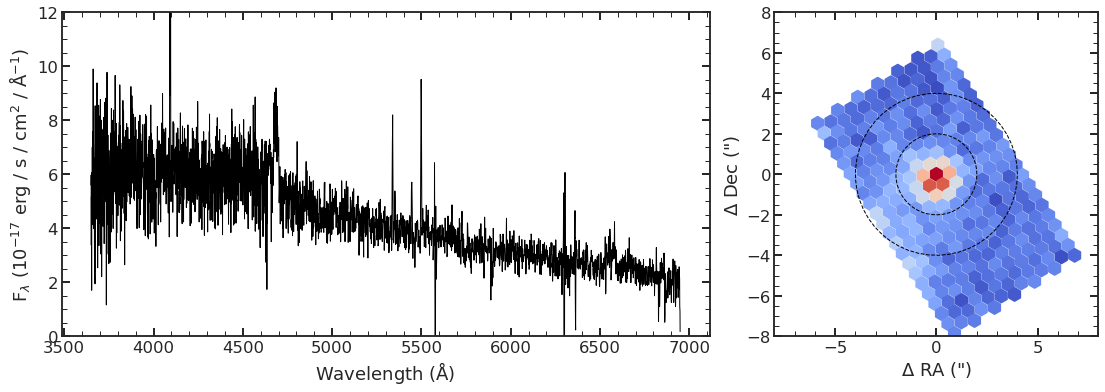

In [29]:
########################################################################
# We are going to reduce the standard star for the night
########################################################################
science_name = 'GW253.750924+14.051330'
objectname = science_name

########################################################################
# Time for our science expsoures
########################################################################
scienceBobs = [key for key, value in zip(keys, values) if ((science_name in value) or ('dark' in value)) and
               (('056' in value) or ('dark' in value))]
scienceRobs = [key for key, value in zip(keys, values) if ((science_name in value) or ('dark' in value)) and
               (('066' in value) or ('dark' in value))]

########################################################################
# Now to begin our basic reductions
# Here we can riff on the current code by entering manual the observation
# number and date we may truly want
########################################################################
scienceB_list = []
for science in scienceBobs:
    date = science.split('_')[0]
    obs = int(science.split('_')[1])
    exp = int(science.split('_')[2])
    scienceB_list.append(LRS2Raw(date, obs, side='blue', basepath=basedir, exposure_number=exp))
scienceR_list = []
for science in scienceRobs:
    date = science.split('_')[0]
    obs = int(science.split('_')[1])
    exp = int(science.split('_')[2])
    scienceR_list.append(LRS2Raw(date, obs, side='red', basepath=basedir, exposure_number=exp))

########################################################################
# Get Fiber to Fiber (i.e., relative normalization) from twilight frames
########################################################################
get_ftf_correction(twiB_list, scienceB_list, side='blue')
get_ftf_correction(twiR_list, scienceR_list, side='red')

########################################################################
# Correct wavelength default to the lamps taken that night
########################################################################
get_wave_correction(HgB_list + CdA_list, scienceB_list, side='blue')
get_wave_correction(HgR_list + FeArR_list, scienceR_list, side='red')

LRS2 = LRS2Object('', lrs2raw_objects=scienceB_list+scienceR_list, detwave=detwave, wave_window=wave_window,
                  red_detect_channel=red_detect_channel,
                  blue_detect_channel=blue_detect_channel,
                  ignore_mask=False)

LRS2.subtract_sky(func=np.nansum, local=False, pca=False, correct_ftf_from_skylines=False,
                  sky_radius=sky_radius, obj_radius=object_radius,
                  ncomp=25, bins=25, peakthresh=2., pca_iter=3,
                  sky_annulus=True, inner_sky_radius=2, outer_sky_radius=outer_sky_radius)

# Set astrometry
LRS2.get_astrometry()
LRS2.extract_spectrum(radius=extraction_radius)
LRS2.smooth_resolution(redkernel=1.8, bluekernel=0.1)
LRS2.rectify(def_wave)
LRS2.normalize()
LRS2.calculate_sn()
LRS2.combine_spectra()
make_quick_plot(LRS2, inner_sky_radius=inner_sky_radius, outer_sky_radius=outer_sky_radius)
